This notebook analyzes the feasibility as utilizing <code>sub_event_type</code> as a tag for sources.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandasql import sqldf

sql = lambda q: sqldf(q, globals())


base_df = pd.read_csv('../data/acled_covid19.csv')
extd_df = pd.read_csv('../data/EXPANDED_acled_covid19.csv')

As seen in the table below, there appears to be 18 different sub event types.

In [3]:
src_df = sql('''
SELECT DISTINCT sub_event_type
FROM extd_df
''')
src_df

,sub_event_type
0,Peaceful protest
1,Protest with intervention
2,Change to group/activity
3,Looting/property destruction
4,Attack
5,Violent demonstration
6,Abduction/forced disappearance
7,Other
8,Mob violence
9,Arrests


Looking at the frequency of these different sub event types per source

In [4]:
query_fmt = ''
for i, t in enumerate(src_df['sub_event_type']):
    t_cln = t.replace(" ", "_")
    t_cln = t_cln.replace("/", "_")
    query_fmt += f'sum(CASE WHEN sub_event_type = "{t}" THEN 1 ELSE 0 END ) AS "{t_cln}"'
    if i < len(src_df['sub_event_type']) - 1:
        query_fmt += ',\n'
        

type_cnt_df = sql(f'''
SELECT source_singular,
{query_fmt}
FROM extd_df
GROUP BY source_singular
''')
type_cnt_df

,source_singular,Peaceful_protest,Protest_with_intervention,Change_to_group_activity,Looting_property_destruction,Attack,Violent_demonstration,Abduction_forced_disappearance,Other,Mob_violence,Arrests,Disrupted_weapons_use,Excessive_force_against_protesters,Remote_explosive_landmine_IED,Sexual_violence,Armed_clash,Grenade,Agreement,Shelling_artillery_missile_attack,Air_drone_strike
0,061.ua,8,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1 News,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10 Tampa Bay,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,10/11 Now,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1010WINS,13,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5357,net.hr,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5358,news.com.au,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5359,nncMX,20,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5360,stiripesurse.ro,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Creating a table to get the total number of events that the source was used by ACLED for

In [5]:
tot_cnt_df = sql(f'''
SELECT source_singular,
count(*) total
FROM extd_df
GROUP BY source_singular
''')
tot_cnt_df

,source_singular,total
0,061.ua,10
1,1 News,5
2,10 Tampa Bay,7
3,10/11 Now,4
4,1010WINS,15
...,...,...
5357,net.hr,29
5358,news.com.au,23
5359,nncMX,21
5360,stiripesurse.ro,1


Creating dataset of the count and percentage of each sub type event that each source was used for

In [6]:
query_fmt = ''
for i, t in enumerate(src_df['sub_event_type']):
    t_cln = t.replace(" ", "_")
    t_cln = t_cln.replace("/", "_")
    t_cln_pct_nm = t_cln + '_pct'
    query_fmt += f'cast({t_cln} AS DOUBLE) / cast(total AS DOUBLE) "{t_cln_pct_nm}"'
    if i < len(src_df['sub_event_type']) - 1:
        query_fmt += ',\n'
        
type_pct_df = sql(f'''
SELECT
    a.*,
    b.total,
{query_fmt}
FROM type_cnt_df a
JOIN tot_cnt_df b
    ON a.source_singular = b.source_singular
''')

type_pct_df.to_csv('../data/source_subeventtype.csv')

type_pct_df[['source_singular', 'total', 'Peaceful_protest', 'Violent_demonstration', 'Peaceful_protest_pct', 'Violent_demonstration_pct']]

,source_singular,total,Peaceful_protest,Violent_demonstration,Peaceful_protest_pct,Violent_demonstration_pct
0,061.ua,10,8,1,0.800000,0.100000
1,1 News,5,4,1,0.800000,0.200000
2,10 Tampa Bay,7,6,0,0.857143,0.000000
3,10/11 Now,4,4,0,1.000000,0.000000
4,1010WINS,15,13,1,0.866667,0.066667
...,...,...,...,...,...,...
5357,net.hr,29,29,0,1.000000,0.000000
5358,news.com.au,23,23,0,1.000000,0.000000
5359,nncMX,21,20,0,0.952381,0.000000
5360,stiripesurse.ro,1,1,0,1.000000,0.000000


The below plot shows that many sources have less than 10 events in the ACLED dataset. We must consider this when designing the tagging process from the user's standpoint. Would it be benificial to tag sources with less than 10 events?

(array([1.542e+03, 6.700e+02, 4.600e+02, 3.310e+02, 2.060e+02, 1.810e+02,
        1.820e+02, 1.420e+02, 1.150e+02, 9.200e+01, 9.700e+01, 6.900e+01,
        8.300e+01, 6.400e+01, 6.100e+01, 5.500e+01, 4.000e+01, 5.400e+01,
        3.700e+01, 3.100e+01, 3.300e+01, 2.300e+01, 3.000e+01, 3.700e+01,
        3.000e+01, 2.600e+01, 1.700e+01, 2.100e+01, 2.200e+01, 1.300e+01,
        2.000e+01, 2.100e+01, 1.400e+01, 1.200e+01, 1.100e+01, 1.400e+01,
        1.800e+01, 1.700e+01, 1.600e+01, 8.000e+00, 1.300e+01, 6.000e+00,
        9.000e+00, 7.000e+00, 1.100e+01, 9.000e+00, 9.000e+00, 7.000e+00,
        1.000e+01, 0.000e+00, 7.000e+00, 8.000e+00, 5.000e+00, 3.000e+00,
        7.000e+00, 7.000e+00, 6.000e+00, 2.000e+00, 3.000e+00, 8.000e+00,
        7.000e+00, 8.000e+00, 5.000e+00, 2.000e+00, 8.000e+00, 2.000e+00,
        2.000e+00, 5.000e+00, 3.000e+00, 7.000e+00, 4.000e+00, 6.000e+00,
        5.000e+00, 2.000e+00, 4.000e+00, 5.000e+00, 3.000e+00, 3.000e+00,
        3.000e+00, 5.000e+00, 3.000e+0

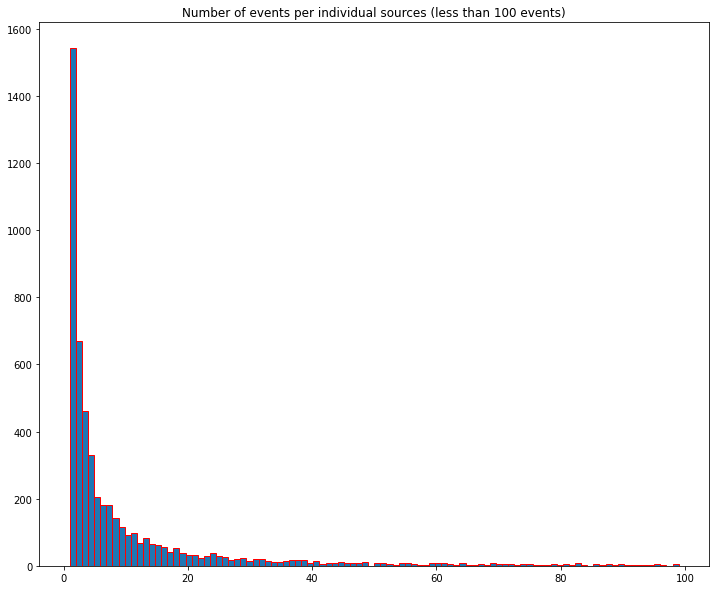

In [7]:
event_lim = 100
type_pct_df_mod = type_pct_df[type_pct_df.total < event_lim]

fig, ax = plt.subplots(figsize=(12,10))
ax.set_title(f'Number of events per individual sources (less than {event_lim} events)')
plt.hist(type_pct_df_mod.total, edgecolor="red", bins=event_lim)

The below plot shows that a few sources have hundreds of events. Again, would these be useful to the user with a sub event type tag?

(array([32., 14., 23., 14., 11.,  6.,  5.,  5.,  4.,  2.,  0.,  5.,  2.,
         2.,  1.,  3.,  2.,  2.,  2.,  3.,  1.,  0.,  0.,  1.,  1.,  0.,
         3.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 100.  ,  114.44,  128.88,  143.32,  157.76,  172.2 ,  186.64,
         201.08,  215.52,  229.96,  244.4 ,  258.84,  273.28,  287.72,
         302.16,  316.6 ,  331.04,  345.48,  359.92,  374.36,  388.8 ,
         403.24,  417.68,  432.12,  446.56,  461.  ,  475.44,  489.88,
         504.32,  518.76,  533.2 ,  547.64,  562.08,  576.52,  590.96,
         605.4 ,  619.84,  634.28,  648.72,  663.16,  677.6 ,  692.04,
        

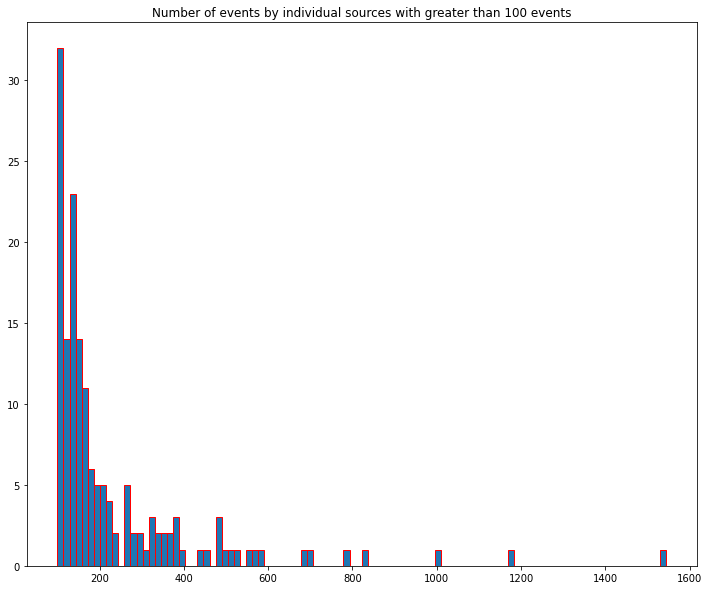

In [8]:
event_lim = 100
type_pct_df_mod = type_pct_df[type_pct_df.total >= event_lim]

fig, ax = plt.subplots(figsize=(12,10))
ax.set_title(f'Number of events by individual sources with greater than {event_lim} events')
plt.hist(type_pct_df_mod.total, edgecolor="red", bins=100)

Each record in the catalog will be a source. We need to determine how many minimum events a source needs for it to be in our catalog. For example, a source with only two events may not be sufficient for a user trying to discover data.

In [9]:
def generate_sub_event_type_df(total_min, total_max, pct_min):
    df = pd.DataFrame(columns=['source_singular', 'sub_event_type', 'sub_event_type_total', 'sub_event_type_pct'])
    for t in src_df['sub_event_type']:
        t_cln = t.replace(" ", "_")
        t_cln = t_cln.replace("/", "_")
        t_cln_pct_nm = t_cln + '_pct'

        query = f'''
        SELECT
            source_singular,
            "{t_cln}_majority" AS "sub_event_type",
            {t_cln} AS "sub_event_type_total",
            {t_cln_pct_nm} AS sub_event_type_pct
        FROM
            type_pct_df
        WHERE 
            total >= {total_min}
            AND total <= {total_max}
            AND {t_cln_pct_nm} >= {pct_min}
        '''

        df1 = sql(query)
        df = pd.concat([df, df1])
        
    return df

In [10]:
generate_sub_event_type_df(total_min=10, total_max=1000, pct_min=0.6)

,source_singular,sub_event_type,sub_event_type_total,sub_event_type_pct
0,061.ua,Peaceful_protest_majority,8,0.800000
1,1010WINS,Peaceful_protest_majority,13,0.866667
2,11 Alive,Peaceful_protest_majority,15,0.937500
3,14 February Revolution Youth Coalition,Peaceful_protest_majority,230,0.978723
4,20 Minutes,Peaceful_protest_majority,34,0.829268
...,...,...,...,...
6,Whatsapp,Violent_demonstration_majority,9,0.818182
0,Anti-Defamation League,Other_majority,25,0.892857
0,Haderi Ha Haredeem,Mob_violence_majority,10,0.714286
1,India Blooms News Service,Mob_violence_majority,7,0.700000
